# PUI 2017 HW 11-1
## Yuwen Chang (ywc249)

### Objective
- Time series clustering exercise
- Cluster patterns of business development (# establishments) in NYC by ZIPTA from 1994-2014
- Attempt different clustering methods
- Visualize the results on maps

### Data
- [Census Bureau Business Data 1993-2014]()
- [NYC Zipcode Shapefile](https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip)

# 1. Data Preparation

In [1]:
import os
import glob
import zipfile
import urllib.request as urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as pl

from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster as spc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1.1 NYC ZIP Shapefile

In [2]:
# download data
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application/zip'
urllib.urlretrieve(url, 'NYCZIP.zip')
os.system('unzip NYCZIP.zip -d ' + os.getenv('PUIDATA') + '/NYCZIP')

256

In [3]:
# locate .shp file
for fname in os.listdir(os.getenv('PUIDATA') + '/NYCZIP'):
    if fname.endswith('shp'):
        shpfile = fname

# read in shapefile
zipshp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/NYCZIP/' + shpfile)
print(zipshp.crs)
zipshp.head()

{'proj': 'lcc', 'lat_1': 40.66666666666666, 'lat_2': 41.03333333333333, 'lat_0': 40.16666666666666, 'lon_0': -74, 'x_0': 300000, 'y_0': 0, 'datum': 'NAD83', 'units': 'us-ft', 'no_defs': True}


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


## 1.2 Business Data

In [4]:
# https://www2.census.gov
# ftp://ftp.census.gov

# download data
!for ((y=93; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2017-12-13 21:17:11--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
Resolving www2.census.gov... 104.88.75.220, 2001:418:143c:180::208c, 2001:418:143c:1ab::208c
Connecting to www2.census.gov|104.88.75.220|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2017-12-13 21:17:12 ERROR 404: Not Found.

--2017-12-13 21:17:12--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
Resolving www2.census.gov... 104.88.75.220, 2001:418:143c:180::208c, 2001:418:143c:1ab::208c
Connecting to www2.census.gov|104.88.75.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: 'zbp94totals.zip.3'

zbp94totals.zip.3   100%[===================>] 597.19K  3.28MB/s    in 0.2s    

2017-12-13 21:17:13 (3.28 MB/s) - 'zbp94totals.zip.3' saved [611524/611524]

--2017-12-13 21:17:13--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp95totals.zip
Resolving www2.census.gov... 104

Resolving www2.census.gov... 104.88.75.220, 2001:418:143c:180::208c, 2001:418:143c:1ab::208c
Connecting to www2.census.gov|104.88.75.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660109 (645K) [application/zip]
Saving to: 'zbp09totals.zip.3'

zbp09totals.zip.3   100%[===================>] 644.64K  3.19MB/s    in 0.2s    

2017-12-13 21:17:19 (3.19 MB/s) - 'zbp09totals.zip.3' saved [660109/660109]

--2017-12-13 21:17:19--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.88.75.220, 2001:418:143c:180::208c, 2001:418:143c:1ab::208c
Connecting to www2.census.gov|104.88.75.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: 'zbp10totals.zip.3'

zbp10totals.zip.3   100%[===================>] 778.84K  3.31MB/s    in 0.2s    

2017-12-13 21:17:20 (3.31 MB/s) - 'zbp10totals.zip.3' saved [797534/797534]

--2017-12-13 21:17:20--  https://www2.census.gov/eco

In [5]:
# locate path and files (reordered by year)
path = os.getenv('PUIDATA')
fnames = glob.glob('zbp*.zip')
fnames = fnames[-6:] + fnames[:-6]
fnames

['zbp94totals.zip',
 'zbp95totals.zip',
 'zbp96totals.zip',
 'zbp97totals.zip',
 'zbp98totals.zip',
 'zbp99totals.zip',
 'zbp00totals.zip',
 'zbp01totals.zip',
 'zbp02totals.zip',
 'zbp03totals.zip',
 'zbp04totals.zip',
 'zbp05totals.zip',
 'zbp06totals.zip',
 'zbp07totals.zip',
 'zbp08totals.zip',
 'zbp09totals.zip',
 'zbp10totals.zip',
 'zbp11totals.zip',
 'zbp12totals.zip',
 'zbp13totals.zip',
 'zbp14totals.zip']

In [6]:
# relocate files to PUIDATA
for f in fnames:
    os.system('mv ' + f + path)

In [7]:
# create a new df with nyc zipcodes as integer
nyczips = zipshp['ZIPCODE'].unique()
dfs = pd.DataFrame(nyczips, columns=['zip'])
dfs['zip'] = dfs['zip'].astype(int)

# read in data one by one, merge with dfs
for f in fnames:
    # unzip file
    zf = zipfile.ZipFile(path + '/' + f)
    df = pd.read_csv(zf.open(f.replace('.zip','.txt')))
    
    # make sure column names are in the same case (lower)
    df.columns = [c.lower() for c in df.columns]
    
    # subset only records residing in nyc
    df = df[[str(z) in nyczips for z in df['zip']]]
    
    # extract only zip and est, then merge
    df = df[['zip', 'est']]
    dfs = dfs.merge(df, on='zip', how='left')

In [8]:
dfs.head()

,zip,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,...,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est
0,11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [9]:
# reset column names
dfs.set_index('zip', inplace=True)
dfs.columns = [str(i) for i in range(1994, 2015)]
dfs.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [10]:
# drop zip codes without any data
df = dfs.dropna(how='all', axis=0)
df.shape

(245, 21)

In [11]:
# standardize
zipmean = df.mean(axis=1)
zipstd = df.std(axis=1)
df = df.apply(lambda x: (x - zipmean) / zipstd)
df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [12]:
# replace NaNs with 0
df.fillna(0, inplace=True)

# 2. Cluster the “number of establishments” time series with K-means (partitioning)

In [13]:
# define a function that does K-means clustering and plot the results
def plotKM(n, data, random=2017):
    """
    Arg:
        1. n: number of clusters (1-10)
        2. data: data to cluster (as dataframe)
        3. random: seed number for random_state
    Return:
        1. append labels back to data as label_km'n'
        2. plot cluster result
    """
    # run K-means
    km = KMeans(random_state=random, n_clusters=n)
    res = km.fit(data.iloc[:,:21])

    # assign results
    data['label_km%s'%n] = res.labels_
    
    # plot results
    pl.figure(figsize=(12,8))

    for l in range(n):
        # subset df and calculate means for each label
        dft = data[data['label_km%s'%n] == l]
        means = dft.mean(axis=0)
        
        pl.subplot(521+l)
        for i in range(len(dft)):
            pl.plot(range(0,21), dft.iloc[i,:21], 'steelblue', alpha=0.3)
            pl.plot(range(0,21), means[0:21], 'indianred', linewidth=2)
        pl.xticks(arange(0,21,5), arange(1994,2015,5), rotation=45)
        pl.title('KM Cluster Label: %s'%l)

    pl.tight_layout()
    pl.show()

# 3. Plot cluster centers: try 3, 5, 7

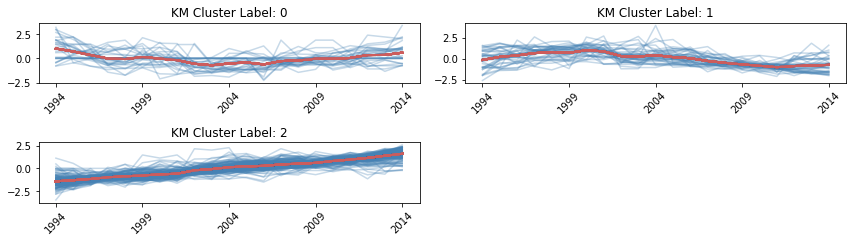

In [14]:
# 3 clusters
plotKM(3, df)

## Fig 1. K-means cluster results of establishment trends for 3 clusters
The results show 2 upward trend (1 slowing down) and a stagnant pattern.

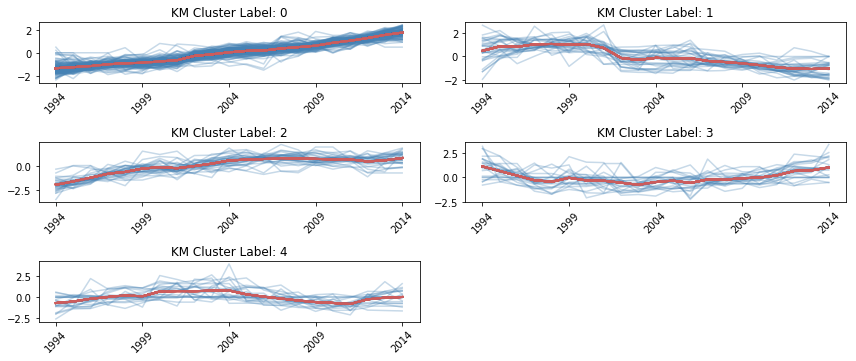

In [15]:
# 5 clusters
plotKM(5, df)

## Fig 2. K-means cluster results of establishment trends for 5 clusters
Aside from previous two upward trends, there is an additional stagnant time series and a declining trend.

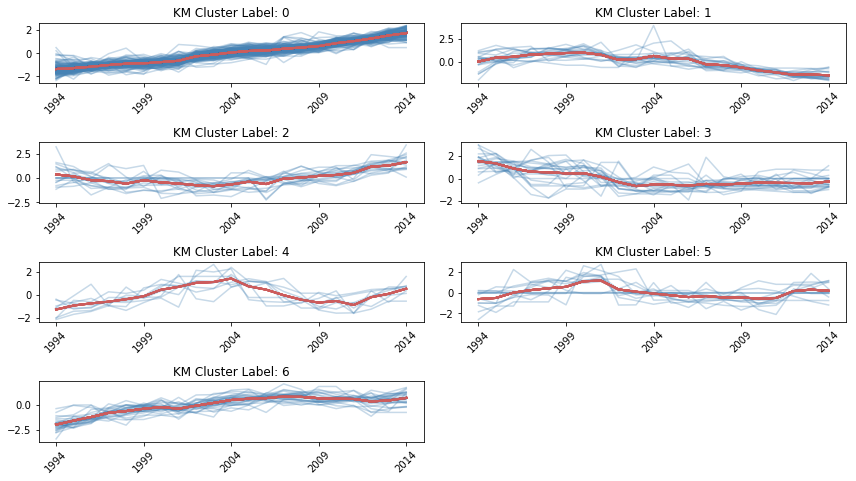

In [16]:
# 7 clusters
plotKM(7, df)

## Fig 3. K-means cluster results of establishment trends for 7 clusters
Upward trends remain apparent, whereas the others are not so different.

In [17]:
# assign labels based on trend patterns for later comparison with agglomerative clustering
# NOTE: these labels may vary, check before comparison
df['label_km'] = df['label_km5'].map({0:'A',
                                      1:'B',
                                      2:'C',
                                      3:'D',
                                      4:'E'})

## Conclusion:
I select 5 clusters for my K-means analysis as 3 seems to be too few (not capturing downward trend) and 7 appears too many (some trends are very similar).

# 4. Cluster the “number of establishments” time series with agglomerative clustering (hierarchichal)

In [18]:
# cluster data with agglomerative clustering
# adopt 5 clusters to compare with K-means
ac = AgglomerativeClustering(n_clusters=5, compute_full_tree=True)
res = ac.fit(df.iloc[:,:21])
df['label_ac5'] = res.labels_

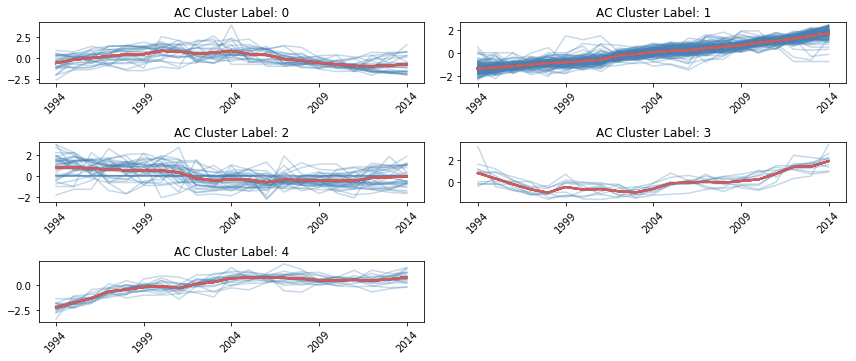

In [19]:
# plot results
pl.figure(figsize=(12,8))
for l in range(5):
    dft = df[df['label_ac5'] == l]
    means = dft.mean(axis=0)
    pl.subplot(521+l)
    for i in range(len(dft)):
        pl.plot(range(0,21), dft.iloc[i,:21], 'steelblue', alpha=0.3)
        pl.plot(range(0,21), means[0:21], 'indianred', linewidth=2)
    pl.xticks(arange(0,21,5), arange(1994,2015,5), rotation=45)
    pl.title('AC Cluster Label: %s'%l)
pl.tight_layout()
pl.show()

## Fig 4. Agglomerative cluster results of establishment trends for 5 clusters
The average trends are slightly different from the result of K-means clustering.

In [20]:
# assign labels based on trend patterns for later comparison with K-means clustering
# NOTE: these labels may vary, check before comparison
df['label_ac'] = df['label_ac5'].map({0:'B',
                                      1:'A',
                                      2:'E',
                                      3:'D',
                                      4:'C'})

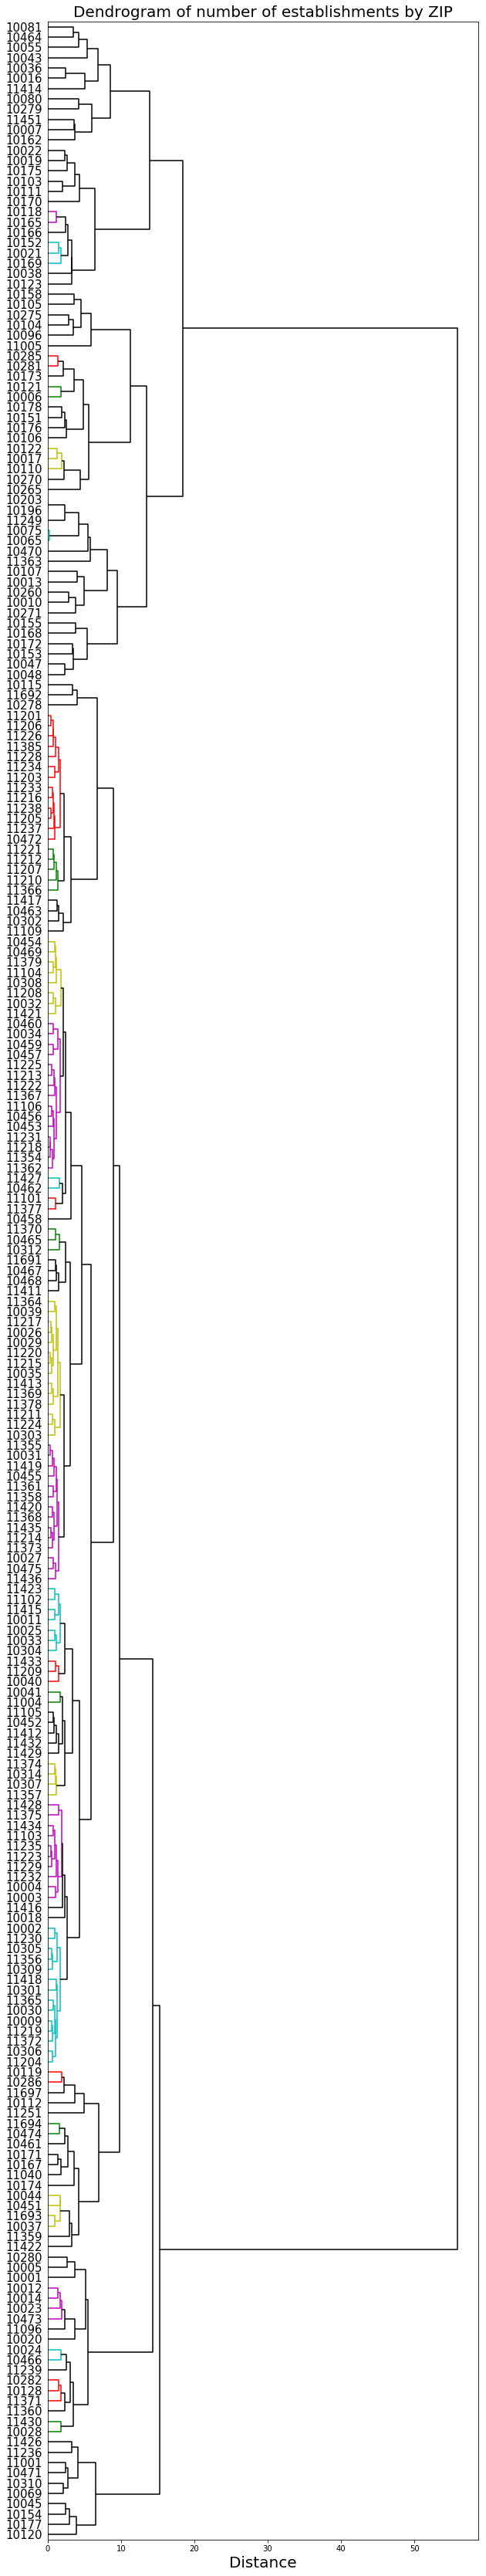

In [21]:
# plot dendrogram
mtx = df.iloc[:,:21].as_matrix(columns=df.iloc[:,:21].columns)

fig = pl.figure(figsize=(10,60))

ddg = spc.hierarchy.dendrogram(spc.hierarchy.linkage(mtx, method='ward'),
                               labels=df.index.values,
                               leaf_rotation=90, leaf_font_size=20, p=12,
                               show_contracted=True, color_threshold=2, 
                               orientation='right', above_threshold_color='k')

pl.xlabel('Distance', fontsize=20)
pl.yticks(rotation=0, fontsize=15)
pl.grid('off')
pl.title('Dendrogram of number of establishments by ZIP', fontsize=20)
pl.show();

## Fig 5. Dendrogram of agglomerative clustering structure

# 5. Overlay clusters on map

In [22]:
# merge labels to NYC ZIPTA shapefile
zipshp['ZIPCODE'] = zipshp['ZIPCODE'].astype(int)
zs = zipshp.merge(df[['label_km', 'label_ac']], left_on='ZIPCODE', right_index=True)

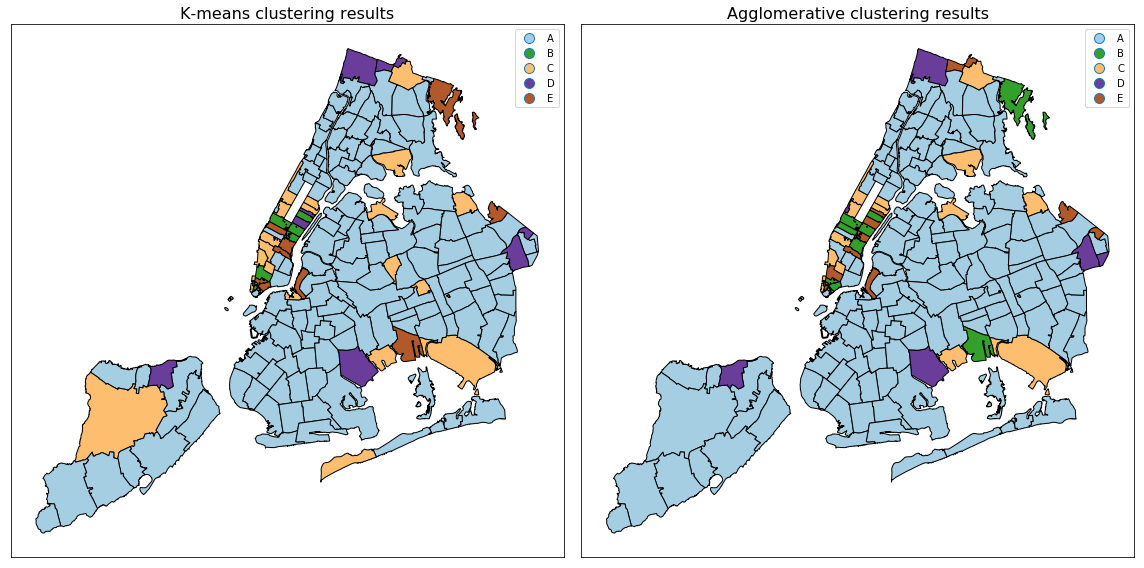

In [23]:
pl.figure(figsize=(16,8))

# plot K-means clustering results
ax1 = pl.subplot(121)
zs.plot(column='label_km', cmap='Paired', edgecolor='black', categorical=True, legend=True, ax=ax1)

ax1.set_title('K-means clustering results', fontsize=16)
ax1.tick_params(axis='both', left='off', bottom='off')
ax1.set_xticklabels('')
ax1.set_yticklabels('')

# plot agglomerative clustering results
ax2 = pl.subplot(122)
zs.plot(column='label_ac', cmap='Paired', edgecolor='black', categorical=True, legend=True, ax=ax2)

ax2.set_title('Agglomerative clustering results', fontsize=16)
ax2.tick_params(axis='both', left='off', bottom='off')
ax2.set_xticklabels('')
ax2.set_yticklabels('')

#pl.suptitle('Trend Patterns of Number of Business Establishments in NYC from 1994-2014', fontsize=20)

pl.tight_layout()
pl.show();

## Fig 6. Trend Patterns of Number of Business Establishments in NYC from 1994-2014
There are five types of major trends of establishment numbers throughout 1994-2014 in NYC, analyzed by ZIPTA.

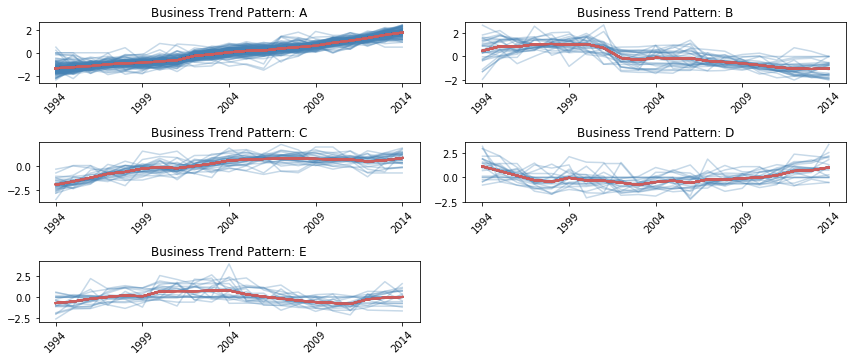

In [24]:
trends = ['A', 'B', 'C', 'D', 'E']

pl.figure(figsize=(12,8))

for l,t in enumerate(trends):
    dft = df[df['label_km5'] == l]
    means = dft.mean(axis=0)

    pl.subplot(521+l)
    for i in range(len(dft)):
        pl.plot(range(0,21), dft.iloc[i,:21], 'steelblue', alpha=0.3)
        pl.plot(range(0,21), means[0:21], 'indianred', linewidth=2)
    pl.xticks(arange(0,21,5), arange(1994,2015,5), rotation=45)
    pl.title('Business Trend Pattern: %s'%t)

pl.tight_layout()
pl.show()

## Fig 7. Types of Trend Patterns

# 6. Compare the results of the 2 algorithms

The majority of results from the two algorithms, as observed from the maps, are not so different. Most areas share pattern A, which is a steady increase. The clustering of trend types B, D, and E are pretty similar as well, although some of them seem interchangeable between two algorithms. These are places where business establishment has no obvious growth throughout time. Those declining (B) are pretty consistent, while stagnant areas may switch between D and E.

The most observable difference is in trend pattern C, which indicates a slowing down in business growth. K-means clustering assigns a lot more areas to this trend pattern.

# 7. Interpret results

We might first conclude that the big environment is generally growing prosperly in the 21-year long run. Interestingly, downtown Manhattan (from Wall St. to Middle East/West) tend to remain stagnant, some areas (e.g., Hell's Kithcen) are even slightly declining. This may be due to that Manhattan has reached its capacity limits (e.g., space, density) for business development. Finally, we might want to explore whether areas that have slowed down in business growth to see if they meet certain challenges. Areas like Staten Island and far end to the East in Brooklyn are examples for this type of trend.

# Random Notes

In [25]:
# tmp = []
# [tmp.append(str(i)) for i in range(94,100)]
# [tmp.append('0' + str(i)) for i in range(10)]
# [tmp.append(str(i)) for i in range(10,15)]
# tmp

# dfs = []
# for i in tmp:
#     fname = path + '/zbp' + i + 'totals.zip'
#     zf = zipfile.ZipFile(fname)
#     df = pd.read_csv(zf.open(fname.replace('.zip', '.txt')))
#     dfs.append(df)
# df = pd.concat(dfs)

# obs = 0
# dfs = []
# for i in tmp:
#     fname = path + '/zbp' + i + 'totals.zip'
#     df = pd.read_csv(fname)
#     df.columns = [c.lower() for c in df.columns]

#     if int(i) < 50:
#         df['year'] = '20' + i
#     else:
#         df['year'] = '19' + i

#     print(df.columns)
#     obs += len(df)
#     dfs.append(df)
# df = pd.concat(dfs)
# print('Concatenate without data loss: %s'%(len(df) == obs))